In [2]:
from jupyterthemes import jtplot
jtplot.style(theme='solarizedl', context='notebook', ticks=True, grid=False, figsize=(10, 6))

In [3]:
from IPython.display import display, Markdown
from tqdm.notebook import tqdm

import random
import requests
import re
from copy import copy
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
# !wget "https://www.wfonts.com/download/data/2016/06/13/malgun-gothic/malgun.ttf"
plt.rc('font', family='Malgun Gothic') 
plt.rcParams['axes.unicode_minus'] = False

from sklearn.preprocessing import normalize
from nltk.tokenize import word_tokenize
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from gensim.models import Word2Vec, FastText

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

___

## Load and Merge

In [5]:
main_df = pd.read_pickle("data/main_df.pickle")

In [6]:
ingredient_df = pd.read_excel("data/ingredient_table.xlsx")
ingredient_df = ingredient_df[['제품명', '업체명', '주성분', '품목기준코드', 'ATC코드']].copy()

In [7]:
main_df['itemseq'] = main_df['itemseq'].astype(int)
merged_df = pd.merge(main_df, ingredient_df, left_on='itemseq', right_on='품목기준코드')

In [8]:
merged_df = merged_df[['itemname', 'entpname', 'efcyqesitm', 'usemethodqesitm', 'atpnqesitm',
       'itemseq', '주성분', 'ATC코드']]

merged_df.rename(columns={'주성분': 'ingredient', 'ATC코드':'atc_cd'}, inplace=True)

In [9]:
label_df = pd.read_pickle("data/label_df.pickle")
label_mapper = pd.read_pickle("data/label_mapper.pickle")

In [10]:
dup_cnt = 0
cls_cd_dict = dict()

mat = label_df[['atc_cd', 'cls_code_num']].values
for idx in range(mat.shape[0]) : 
    cd, num = mat[idx]
    if cls_cd_dict.get(cd) is None : 
        cls_cd_dict[cd] = num
    else : 
        if cls_cd_dict[cd] == num : 
            pass
        else : 
#             print("key : {} | existing value : {} | new value : {}".format(cd, cls_cd_dict[cd], num))
            dup_cnt += 1
            
print("{}% of data is duplicated".format(np.round(dup_cnt / float(len(mat)) * 100, 3)))

4.286% of data is duplicated


In [11]:
merged_df['CLS_CODE'] = merged_df.atc_cd.map(lambda x : cls_cd_dict.get(x))
label_df = merged_df[merged_df.CLS_CODE.notnull()].copy()
label_df['CLS_NM'] = label_df.CLS_CODE.map(lambda x : label_mapper.get(x))
label_df = label_df[label_df.CLS_NM.notnull()].copy()

In [12]:
label_df.CLS_NM.value_counts().head(10)

해열·진통·소염제       729
기타의 비타민제        456
진통·진양·수렴·소염제    334
기생성 피부질환용제       99
정장제              94
치과구강용약           94
제산제              88
항히스타민제           84
안과용제             78
건위소화제            75
Name: CLS_NM, dtype: int64

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


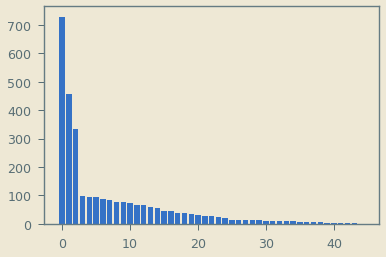

In [13]:
count_df = label_df.CLS_NM.value_counts()
plt.bar(range(len(count_df)), count_df.values)
plt.show()